# Exploratory Stuff

In [1]:
# init

from matplotlib import pyplot
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import seaborn as sns

from covid19stats import *

conn = get_db_conn()

sns.set(style="darkgrid")

N=5696


,Confirmed,Deaths
Confirmed,1.000000,0.935533
Deaths,0.935533,1.000000


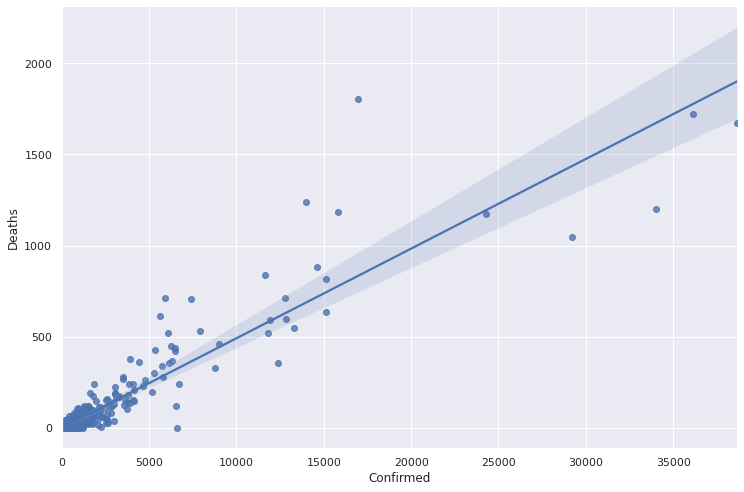

In [2]:
# sanity check: is this thing on?
# of course confirmed cases will be highly correlated with deaths, duh

sql = """
SELECT
    Confirmed,
    Deaths
FROM fact_counties_ranked cr
WHERE
    Date = '20200501'
    -- exclude NYC outlier 
    AND cr.FIPS <> '36061'
"""

df = psql.read_sql(sql, conn)
print(f"N={df.size}")

sns.lmplot(x="Confirmed", y="Deaths", data=df, height=7, aspect=1.5)

df.corr()

N=5686


,Confirmed,Population
Confirmed,1.000000,0.610373
Population,0.610373,1.000000


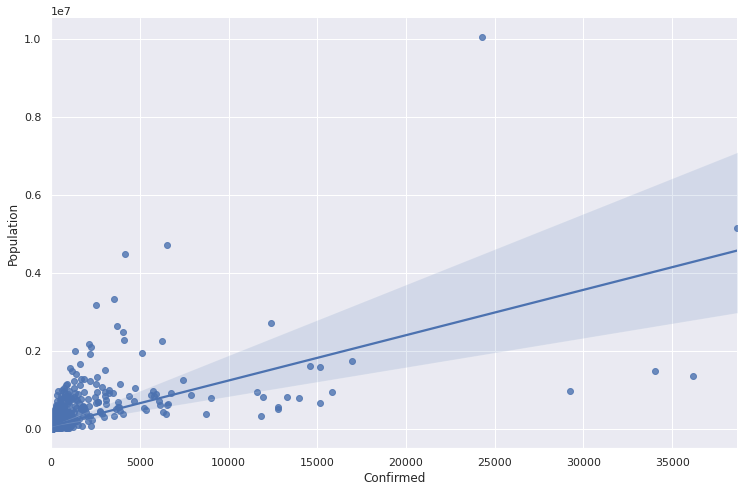

In [3]:
# is there a correlation with population size?
# we'd expect so, since outbreaks began in large cities.
# correlation probably decreases over time

sql = """
SELECT
    Confirmed,
    Population
FROM fact_counties_ranked cr
JOIN dim_county c
    ON cr.FIPS = c.FIPS
WHERE
    Date = '20200501'
    AND Population > 0
    AND Confirmed >= 0
    -- exclude NYC outlier 
    AND cr.FIPS <> '36061'
"""

df = psql.read_sql(sql, conn)
print(f"N={df.size}")

sns.lmplot(x="Confirmed", y="Population", data=df, height=7, aspect=1.5)

df.corr()

N=5384


,Deaths,MedianAge
Deaths,1.000000,-0.067061
MedianAge,-0.067061,1.000000


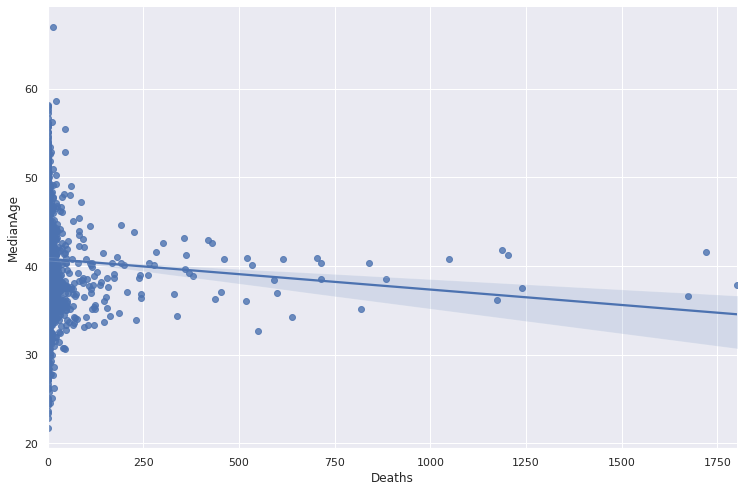

In [4]:
# no correlation with median age, which is odd

sql = """
SELECT
    Deaths,
    MedianAge
FROM fact_counties_ranked cr
JOIN dim_county c
    ON cr.FIPS = c.FIPS
WHERE
    Date = '20200501'
    AND MedianAge > 0
    AND Deaths >= 0
    -- exclude NYC outlier 
    AND cr.FIPS <> '36061'
"""

df = psql.read_sql(sql, conn)
print(f"N={df.size}")

sns.lmplot(x="Deaths", y="MedianAge", data=df, height=7, aspect=1.5)

df.corr()

,Deaths,MedianAge
Deaths,1.000000,-0.204822
MedianAge,-0.204822,1.000000


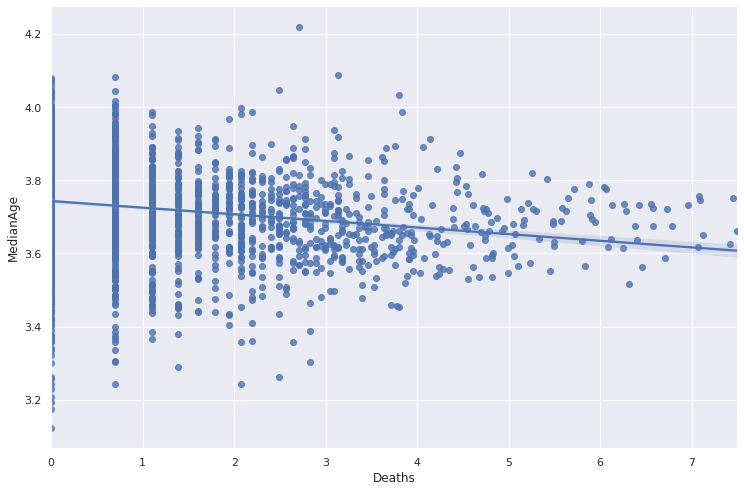

In [5]:
# try log transform to spread out the data

sns.lmplot(x="Deaths", y="MedianAge", data=np.log1p(df), height=7, aspect=1.5)

np.log1p(df).corr()

N=5382


,Confirmed,MedianIncome
Confirmed,1.000000,0.248784
MedianIncome,0.248784,1.000000


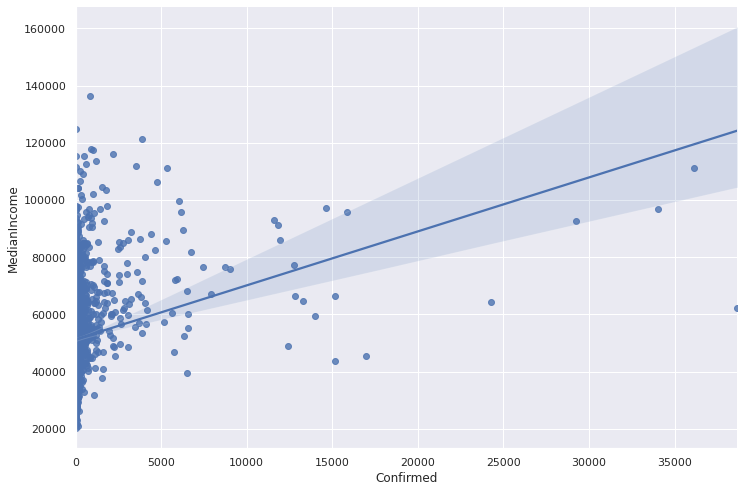

In [6]:
# very slight correlation with median income?

sql = """
SELECT
    Confirmed,
    MedianIncome
FROM fact_counties_ranked cr
JOIN dim_county c
    ON cr.FIPS = c.FIPS
WHERE
    Date = '20200501'
    AND MedianIncome > 0
    AND Confirmed >= 0
    -- exclude NYC outlier 
    AND cr.FIPS <> '36061'
"""

df = psql.read_sql(sql, conn)
print(f"N={df.size}")

sns.lmplot(x="Confirmed", y="MedianIncome", data=df, height=7, aspect=1.5)

df.corr()

N=5382


,ConfirmedPer1M,MedianIncome
ConfirmedPer1M,1.000000,0.092547
MedianIncome,0.092547,1.000000


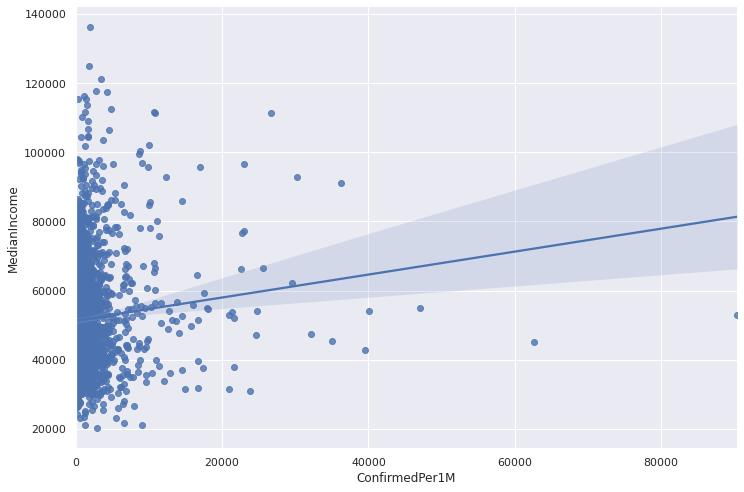

In [7]:
# try median income again, but with ConfirmedPer1M this time.
# it's not clear to me whether you can use counts adjusted to the pop in calculating correlation coefficient

sql = """
SELECT
    ConfirmedPer1M,
    MedianIncome
FROM fact_counties_ranked cr
JOIN dim_county c
    ON cr.FIPS = c.FIPS
WHERE
    Date = '20200501'
    AND MedianIncome > 0
    AND ConfirmedPer1M >= 0
    -- exclude NYC outlier 
    AND cr.FIPS <> '36061'
"""

df = psql.read_sql(sql, conn)
print(f"N={df.size}")

sns.lmplot(x="ConfirmedPer1M", y="MedianIncome", data=df, height=7, aspect=1.5)

df.corr()